In [410]:
import numpy as np

from sklearn import mixture
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity

from scipy.stats.distributions import norm, uniform, bernoulli

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from PIL import Image

In [412]:
FIG_PATH = "../presentation/figures"
DATASET_PATH = '../datasets/segmentation-evaluation-database/1obj'

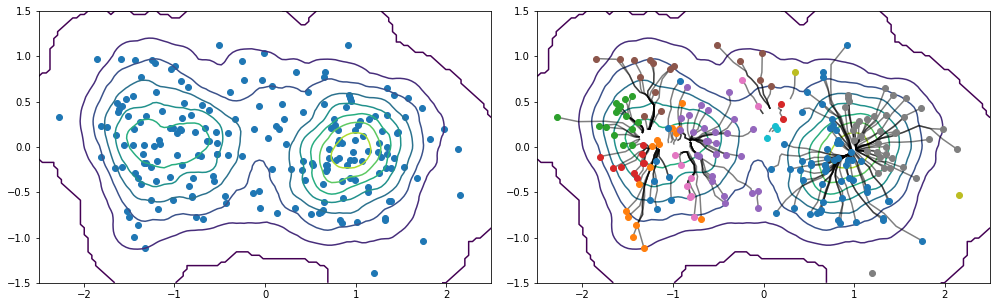

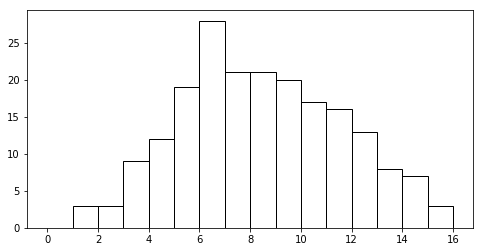

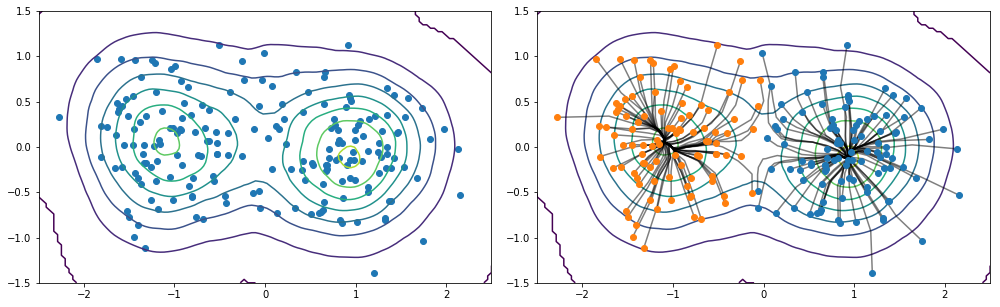

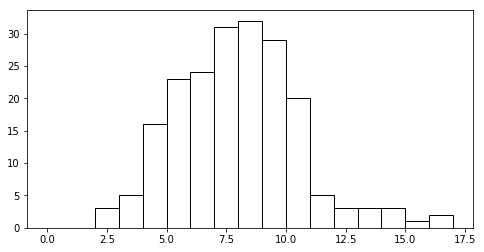

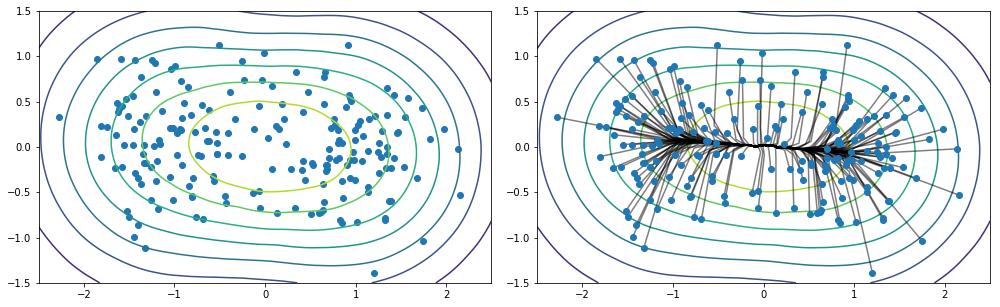

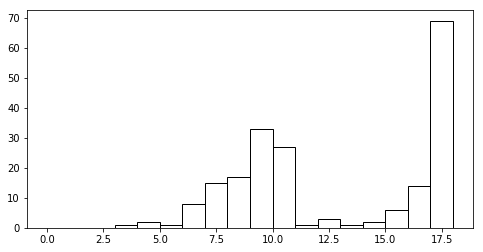

In [422]:
def figure_trajectories():
    np.random.seed(0)

    X_train, y_true = make_blobs(n_samples=200, n_features=2, centers=[[-1, 0], [1, 0]], cluster_std=[0.5, 0.5])
    
    
    def kde(X, Z, kernel):
        n, d = X.shape
        res = np.zeros(Z.shape[0])
        for i, x in enumerate(Z):
            d = np.sqrt(np.sum((X - x)**2, axis=1))
            res[i] = kernel(d).sum()
        return res

    def m(X, x, kernel):
        norm = np.sqrt(np.sum((X - x)**2, axis=1))
        w = kernel(norm)
        return w @ X / w.sum()

    def get_its(x_start):
        x = x_start
        its = []
        for _ in range(200):
            x_new = m(X_train, x, kernel)
            its.append(x)
            if np.sum((x_new - x)**2) < 1e-5:
                break
            else:
                x = x_new
        return np.array(its)
    
    def connected_components(Z, epsilon=0.05):
        n, _ = Z.shape
        clusters = -np.ones(n, dtype=int)
        while np.any(clusters < 0):
            x = Z[clusters < 0][0]
            d = np.sqrt(np.sum((Z - x)**2, axis=1))
            clusters[d < epsilon] = np.max(clusters) + 1
        return clusters
    
    
    def plot_dataset(ax):
        ax.scatter(X_train[:,0], X_train[:,1])

    def plot_kde(ax):
        n = 40
        x = np.linspace(-2.5, 2.5, 3 * n)
        y = np.linspace(-1.5, 1.5, 2 * n)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T

        pdf = kde(X_train, XX, kernel_shadow).reshape(X.shape)
        ax.contour(X, Y, pdf, antialiased=True)
    
    def plot_trajectories(ax):
        Z = np.zeros(X_train.shape)
        T = np.zeros(X_train.shape[0], dtype=int)
        for i, x_i in enumerate(X_train):
            its = get_its(x_i)
            Z[i] = its[-1]
            T[i] = its.shape[0]
            ax.plot(its[:,0], its[:,1], '-', color='black', alpha=0.5)
        return connected_components(Z), T
    
    def plot_clustering(ax, c):
        for i in np.unique(c):
            ax.scatter(X_train[c == i, 0], X_train[c == i, 1], zorder=10)
    
    
    kernel_name = 'uniform'

    if kernel_name == 'gaussian':
        hs = [0.15, 0.35, 0.8]
    elif kernel_name == 'uniform':
        hs = [0.5, 0.8, 1.7]
    
    # h = 0.15 # 0.25 # 0.35 # 0.75 # 0.25
    
    
    for h in hs:
        if kernel_name == 'gaussian':
            kernel_shadow = kernel = norm(0, h).pdf
        elif kernel_name == 'uniform':
            kernel = uniform(-h, 2*h).pdf
            kernel_shadow = lambda u: 3/4 * (1 - (u / h)**2) * (np.abs(u / h) < 1)
        
        fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

        plot_dataset(axes[0])
        
        for ax in axes:
            plot_kde(ax)
        
        C, T = plot_trajectories(axes[1])
        plot_clustering(axes[1], C)


        for ax in axes:
            ax.set_aspect('equal', 'box')
        
        fig.tight_layout()
        plt.savefig(f'{FIG_PATH}/contour/kde-and-trajectories-h={h}-K={kernel_name}.pdf', dpi=300, transparent=True)
        plt.show()

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.hist(T, bins=range(0, T.max() + 1), fill=False)
        plt.savefig(f'{FIG_PATH}/contour/hist-h={h}-K={kernel_name}.pdf', dpi=300, transparent=True)
        plt.show()


figure_trajectories()

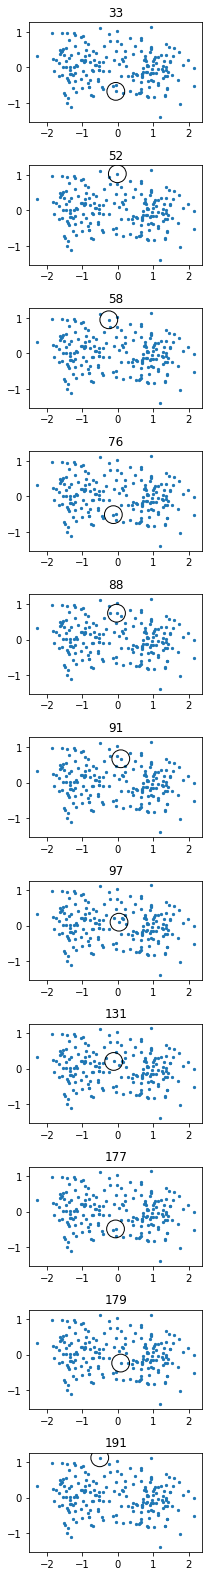

In [25]:
np.random.seed(0)
X_train, y_true = make_blobs(n_samples=200, n_features=2, centers=[[-1, 0], [1, 0]], cluster_std=[0.5, 0.5])
n, _ = X_train.shape

ids = [33, 52, 58, 76, 88, 91, 97, 131, 177, 179, 191]
k = len(ids)

fig, axes = plt.subplots(nrows=k, figsize=(4, 2 * k))

for i, ax in zip(ids, axes):
    ax.scatter(X_train[:, 0], X_train[:, 1], 5)
    ax.add_patch(Circle(X_train[i], 0.25, fill=False))
    ax.set_title(i)
    ax.set_aspect('equal', 'box')

fig.tight_layout()
plt.show()

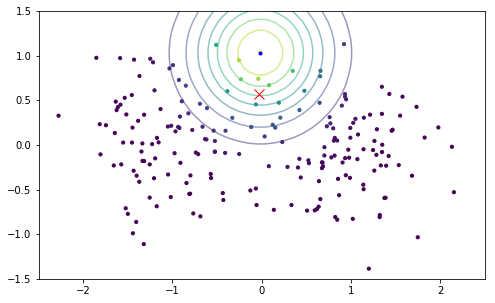

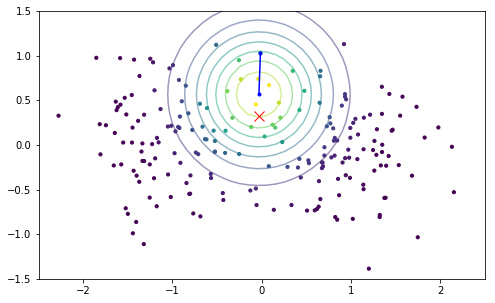

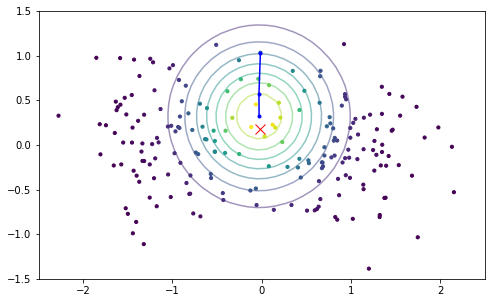

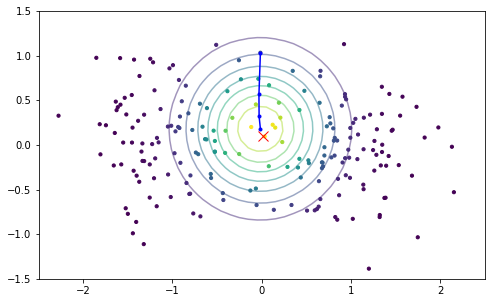

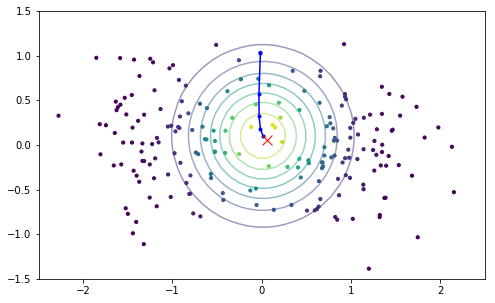

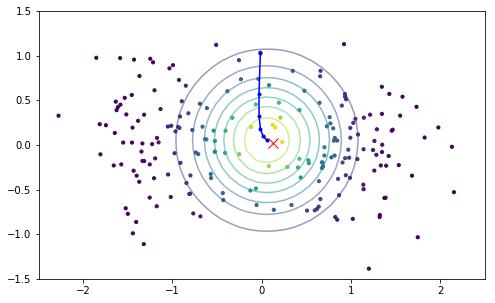

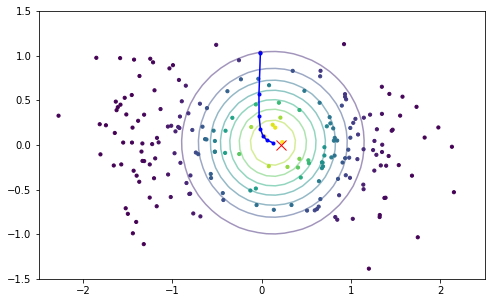

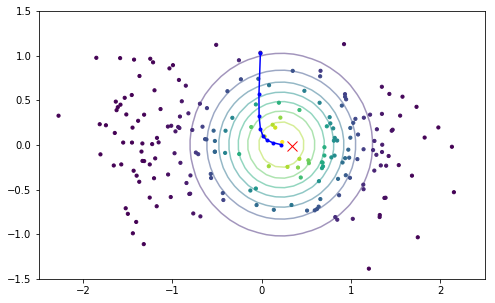

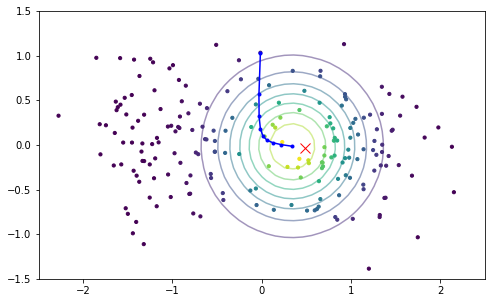

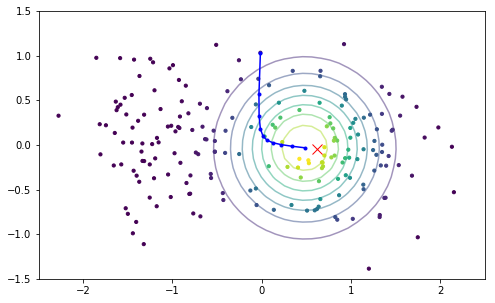

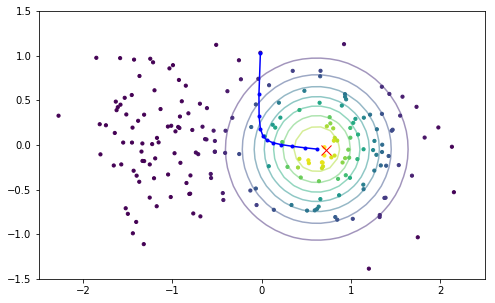

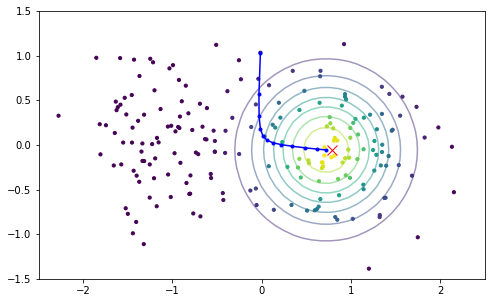

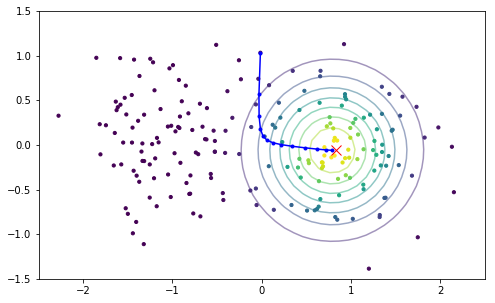

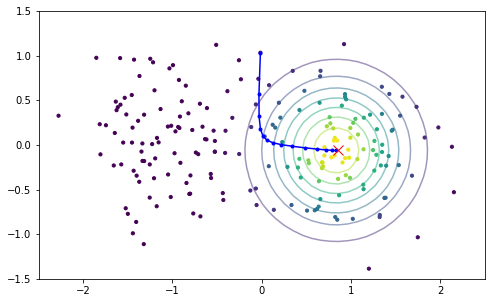

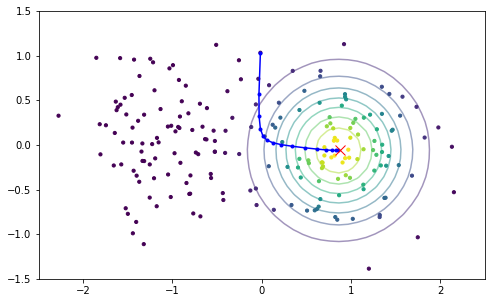

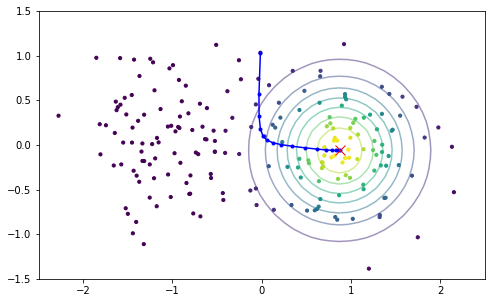

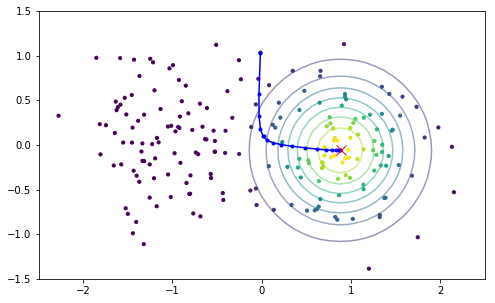

In [371]:
from matplotlib.animation import FuncAnimation

def figure_trajectories_animation():
    np.random.seed(0)
    X_train, y_true = make_blobs(n_samples=200, n_features=2, centers=[[-1, 0], [1, 0]], cluster_std=[0.5, 0.5])
    
    def kde(X, Z, kernel):
        n, d = X.shape
        res = np.zeros(Z.shape[0])
        for i, x in enumerate(Z):
            d = np.sqrt(np.sum((X - x)**2, axis=1))
            res[i] = kernel(d).sum()
        return res

    def m(X, x, kernel):
        d = np.sqrt(np.sum((X - x)**2, axis=1))
        w = kernel(d)
        return w @ X / w.sum()

    def get_its(x_start, X, kernel):
        x = x_start
        its = []
        for _ in range(50):
            x_new = m(X, x, kernel)
            its.append(x)
            if np.sum((x_new - x)**2) < 1e-5:
                break
            else:
                x = x_new
        return np.array(its)
    
    def plot_kde(kernel, z):
        n = 20
        x = np.linspace(-3., 3., 3 * n)
        y = np.linspace(-2., 2., 2 * n)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T

        pdf = kde(np.array([z]), XX, kernel).reshape(X.shape)
        ax.contour(X, Y, pdf, antialiased=True, alpha=0.5)
    
    

    # h = 0.5 # 0.75 # 0.25
    kernel_name = 'gaussian'
    
    if kernel_name == 'gaussian':
        h = 0.5
        kernel = norm(0, h).pdf
        start_idx = 52
    elif kernel_name == 'uniform':
        h = 0.5
        kernel = uniform(-h, 2*h).pdf
        start_idx = 0

    
    its = get_its(X_train[start_idx], X_train, kernel)
    for i in range(0, len(its)-1):
        fig, ax = plt.subplots(figsize=(8, 5))
        
        d = np.sqrt(np.sum((X_train - its[i])**2, axis=1))
        c = kernel(d)
        ax.scatter(X_train[:, 0], X_train[:, 1], s=10, c=(c / c.max()), label=r'$x_i$')
        
        ax.plot(its[:i+1,0], its[:i+1,1], 'b.-', label=r'$x^{(\tau)}$')
        ax.plot(its[i+1,0], its[i+1,1], 'rx', markersize=10)
        
        if kernel_name == 'gaussian':
            plot_kde(kernel, its[i])
        elif kernel_name == 'uniform':
            ax.add_patch(Circle(its[i], radius=h, fill=False, alpha=0.5))


        ax.set_ylim((-1.5, 1.5))
        ax.set_xlim((-2.5, 2.5))
        ax.set_aspect('equal', 'box')
        
        # fig.tight_layout()
        # fig.legend(loc=(0.8, 0.2))

        plt.savefig(f'{FIG_PATH}/iterations-{kernel_name}/step-{i+1}.pdf', dpi=300, transparent=True)
        plt.show()

figure_trajectories_animation()

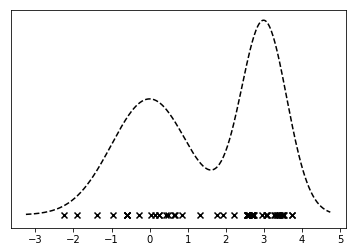

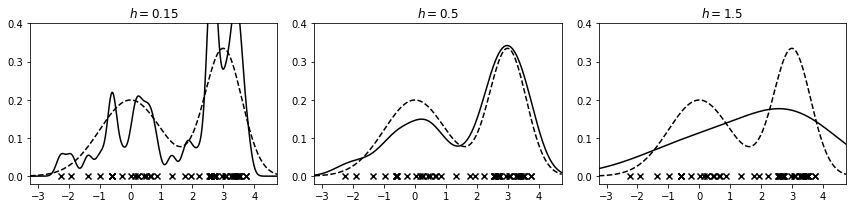

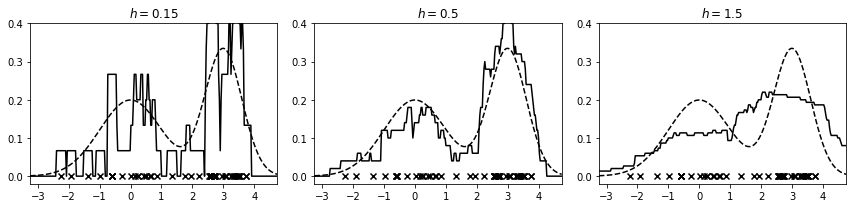

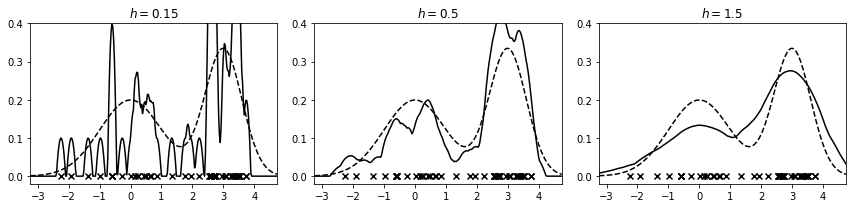

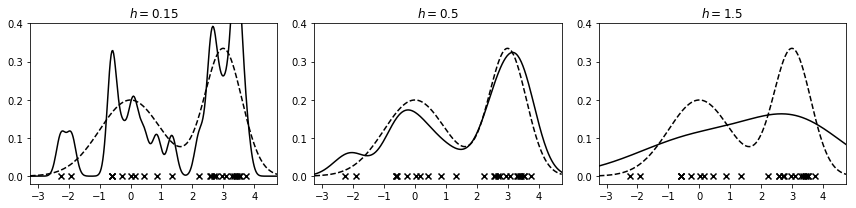

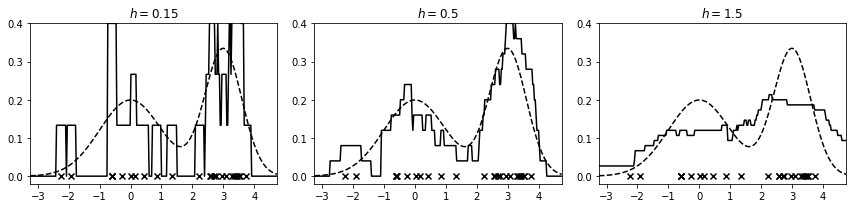

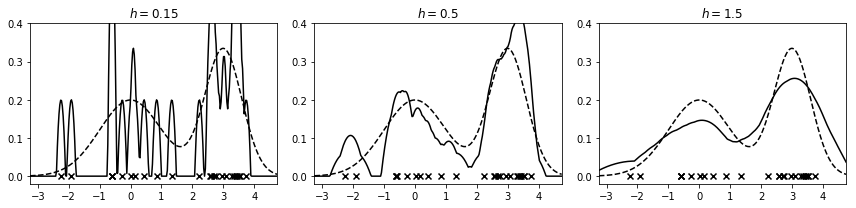

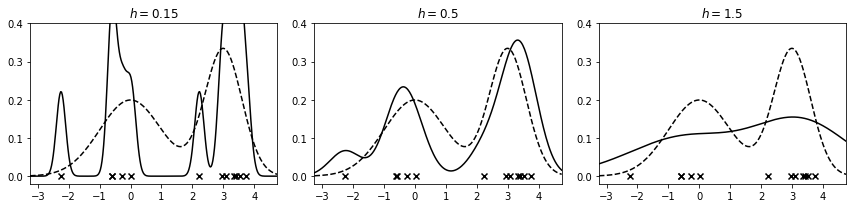

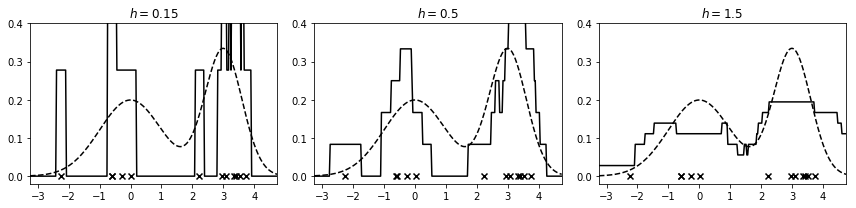

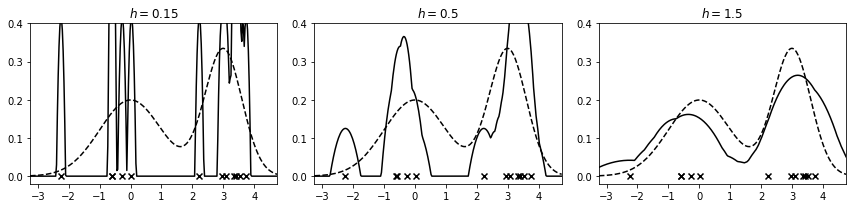

In [441]:
def figure_kernel_density_estimation():
    np.random.seed(3)
    
    n = 50
    alpha = 0.5
    p1 = norm(0, 1)
    p2 = norm(3, 0.6)
    b = bernoulli(alpha).rvs(n)
    all_samples = b * p1.rvs(n) + (1 - b) * p2.rvs(n)
    pdf = lambda x: alpha * p1.pdf(x) + (1 - alpha) * p2.pdf(x)
        
    
    def kde(samples, z, kernel):
        n, = samples.shape
        res = np.zeros_like(z)
        for i, x in enumerate(z):
            d = np.abs(samples - x)
            res[i] = kernel(d).sum() / n
        return res
    
    x = np.linspace(all_samples.min() - 1, all_samples.max() + 1, 300)
    
    
    fig, ax = plt.subplots()    
    ax.plot(x, pdf(x), 'k--', label=r'$f(x)$')
    ax.scatter(all_samples, np.zeros_like(all_samples), marker='x', color='k', label=r'$x_i$')
    # ax.scatter(all_samples, np.random.uniform(size=all_samples.shape) * pdf(all_samples) * 0.1, marker='x', color='k')
    ax.set_yticks([])
    # fig.legend(loc=(0.78, 0.75))
    plt.savefig(f'{FIG_PATH}/samples-and-underlying-pdf.pdf', dpi=300, transparent=True)
    plt.show()
    
    
    for samples in [all_samples, all_samples[:n//2], all_samples[:n//4]]:
        for kernel_name in ['gaussian', 'uniform', 'epanechnikov']:
            fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
            for ax, h in zip(axes, [0.15, 0.5, 1.5]):
                if kernel_name == 'gaussian':
                    kernel = norm(0, h).pdf
                elif kernel_name == 'uniform':
                    kernel = uniform(-h, 2*h).pdf
                elif kernel_name == 'epanechnikov':
                    kernel = lambda x: 1/h * 3/4 * (1 - (x/h)**2) * ((x/h)**2 < 1)

                ax.plot(x, pdf(x), 'k--')
                ax.scatter(samples, np.zeros_like(samples), marker='x', color='k', s=6**2)
                # ax.scatter(samples, np.random.uniform(size=samples.shape) * pdf(samples) * 0.1, marker='x', color='k')
                # ax.scatter(samples, np.random.uniform(size=samples.shape) * p.pdf(samples))

                ax.set_title(f"$h = {h}$")
                ax.plot(x, kde(samples, x, kernel), 'k-')
                
                ax.set_ylim((-0.02, 0.4))
                ax.set_xlim((x.min(), x.max()))

            fig.tight_layout()

            plt.savefig(f'{FIG_PATH}/kernel-density-estimation-{kernel_name}-{samples.shape[0]}.pdf', dpi=300, transparent=True)
            plt.show()


figure_kernel_density_estimation()

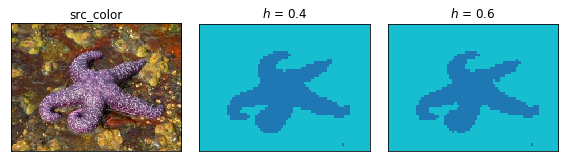

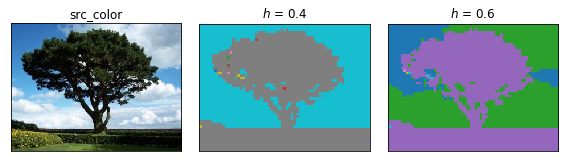

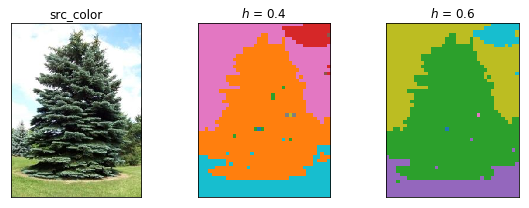

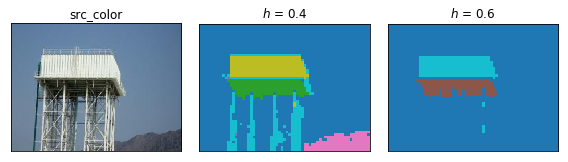

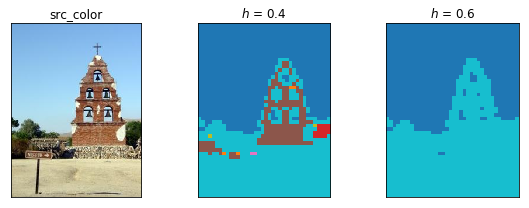

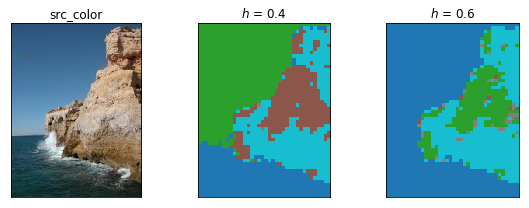

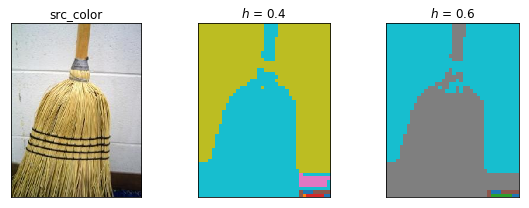

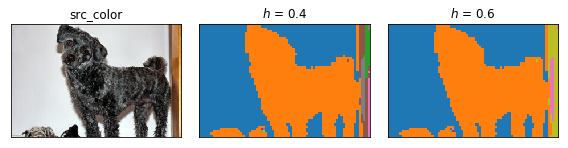

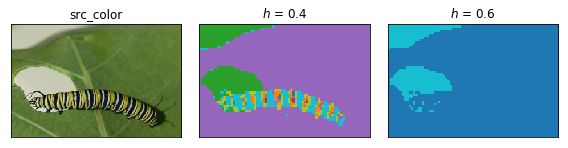

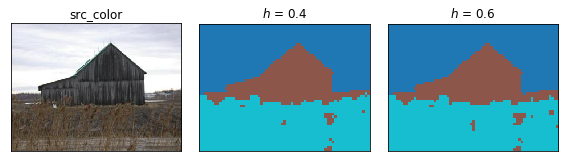

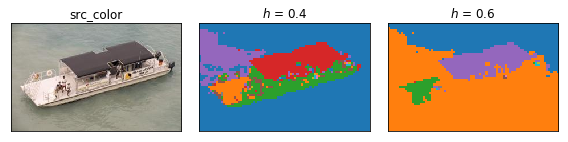

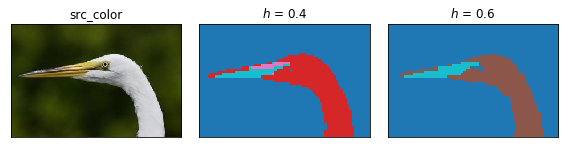

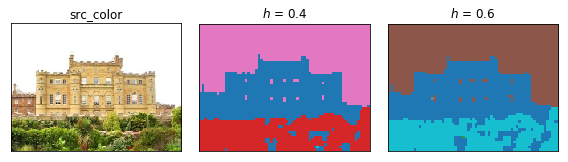

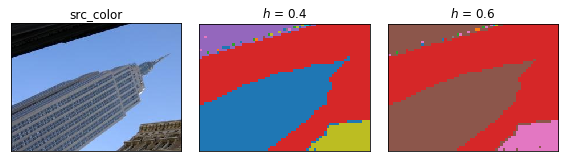

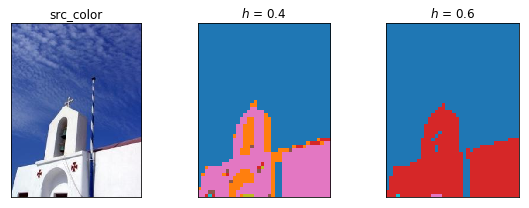

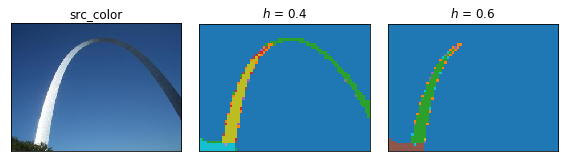

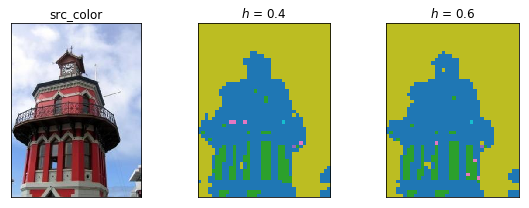

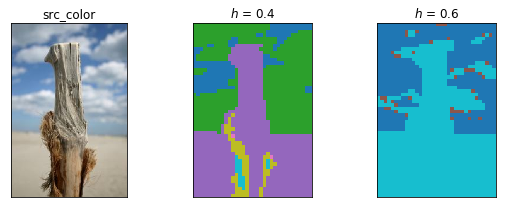

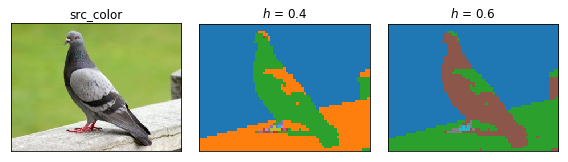

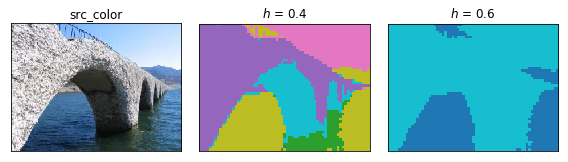

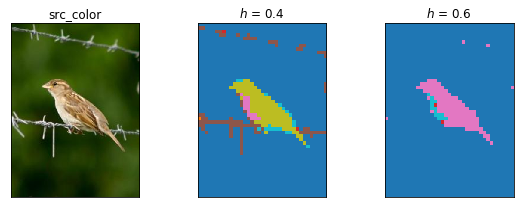

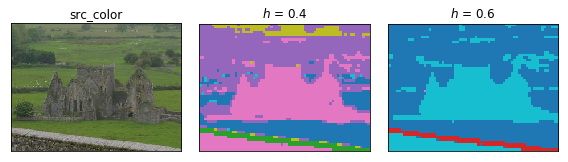

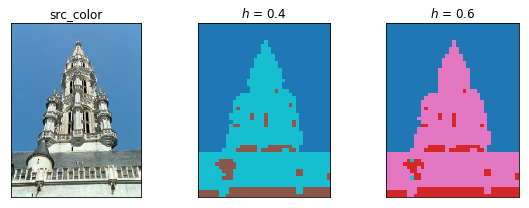

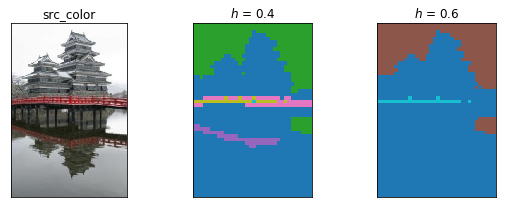

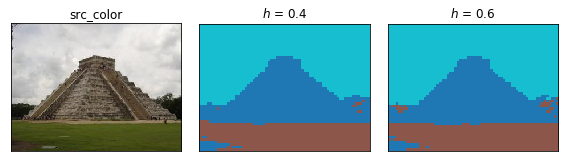

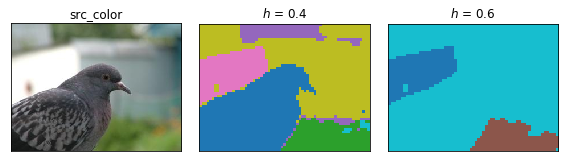

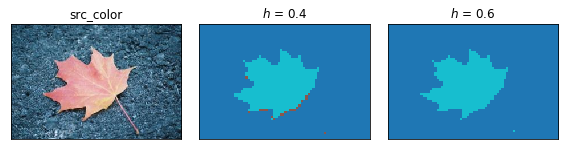

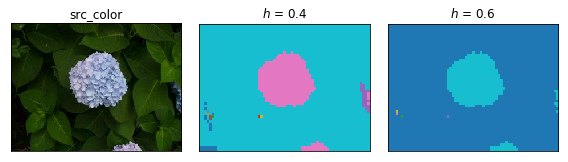

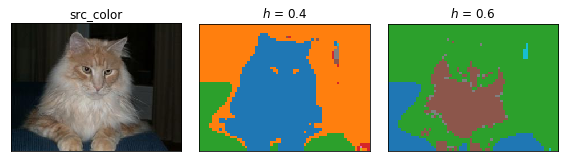

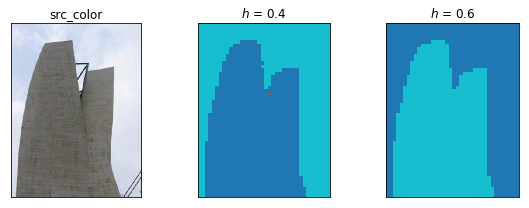

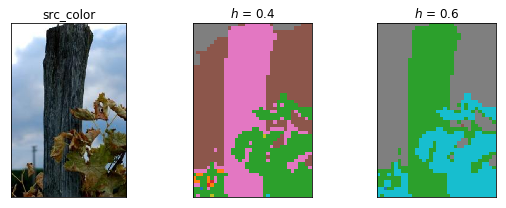

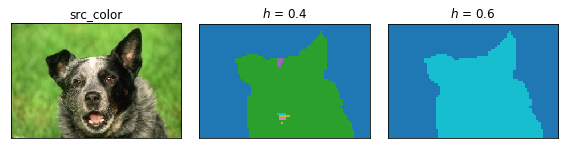

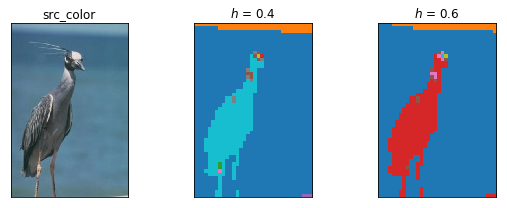

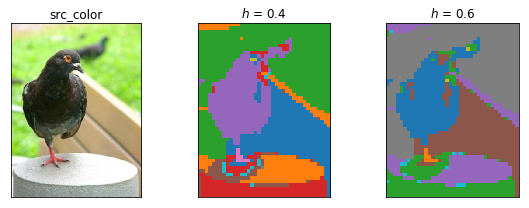

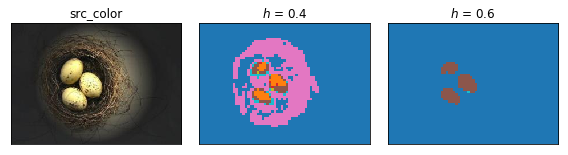

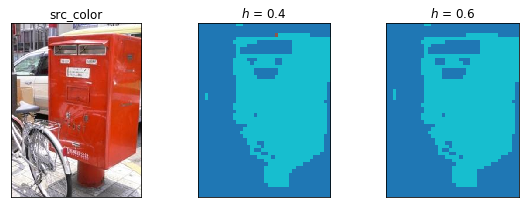

In [414]:
selected_names = """skookumchuk_starfish1
100_0109
100_0497
114591144943
b14pavel013
b20nature_landscapes129
broom07
bw4
caterpiller
chaom38
crw_0384
egret_face
culzeancastle
estb_img_6461_
europe_holiday_484
imgp2712
img_1965
img_2592_f
img_3083_modif
img_4214
img_4730_modif
ireland_62_bg_061502
kconnors030466
matsumt060102_dyj08
mexico3
dscf3583
leafpav
nitpix_p1280114
oscar2005_05_07
outside_guggenheim_walls
palovigna
pic0203vn0092
pic0203vn0105
pic109250805856
picture_458
postjp""".split('\n')


def plot_pictures(names):
    for name in names:
        fig, axes = plt.subplots(ncols=3,figsize=(8, 3))
        axes[0].imshow(Image.open(f"{DATASET_PATH}/{name}/src_color/{name}.png"))
        axes[1].imshow(np.array(Image.open(f"{DATASET_PATH}/{name}/algo_seg/{name}-h=0.4-K=gaussian.png")), cmap='tab10')
        axes[2].imshow(np.array(Image.open(f"{DATASET_PATH}/{name}/algo_seg/{name}-h=0.6-K=gaussian.png")), cmap='tab10')

        for ax in axes.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        for ax, title in zip(axes, ['src_color', '$h$ = 0.4', '$h$ = 0.6']):
            ax.set_title(title)

        fig.tight_layout()
        plt.savefig(f'{FIG_PATH}/segmentation/segmentation-results-{name}.png', dpi=150)
        plt.show()

plot_pictures(selected_names)